In [1589]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
#from mordred import Calculator, descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt


from sklearn import svm, ensemble, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix


In [1590]:
df = pd.read_csv("pIC50.csv")
df

,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


In [1591]:
#from sklearn.datasets import load_iris

In [1592]:
#iris = load_iris()
#
#iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
#iris_df.head()
#iris_df.shape
#

In [1593]:
#iris_X = np.array(iris_df)
#iris_X

In [1594]:
    #iris_df['target'] = iris.target
    #iris_y = np.array(iris_df['target'])
    #iris_y.shape

<Figure size 2000x2000 with 0 Axes>

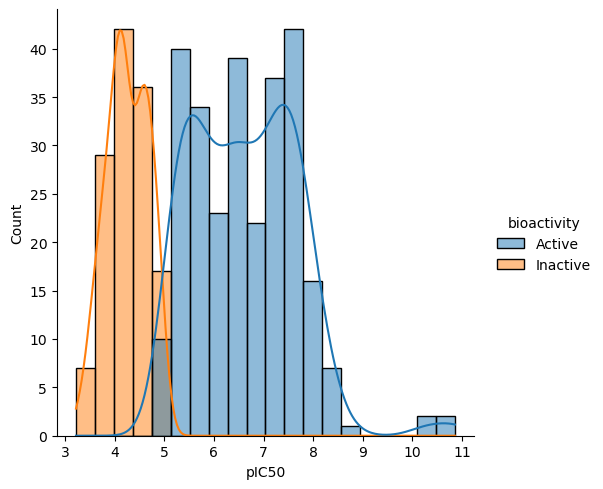

In [1595]:
plt.figure(figsize=(20, 20))

sns.displot(df, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [1596]:
df2 = df[["cid", "smiles", "pIC50"]]
df2

,cid,smiles,pIC50
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970
...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823


In [1597]:
df2["activity_label"] = np.zeros(len(df2))

df2.loc[df2[df2.pIC50 >= 5].index, "activity_label"] = 1.0

print("Number of active molecules:", int(df2.activity_label.sum()))
print("Number of inactive molecules:", len(df2) - int(df2.activity_label.sum()))

df

Number of active molecules: 275
Number of inactive molecules: 131


C:\Users\supak\AppData\Local\Temp\ipykernel_14964\901482849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["activity_label"] = np.zeros(len(df2))


,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


Create Fingerprint

In [1598]:
def fingerprints(smiles, method="maccs", n_bits=2048):

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan4":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [1599]:
compound_df = df2.copy()

compound_df["fp"] = compound_df["smiles"].apply(fingerprints)
compound_df

,cid,smiles,pIC50,activity_label,fp
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [1600]:
compounds_maccs = []

for _, smiles, bioactivity in df[['smiles', 'bioactivity']].itertuples():
    compounds_maccs.append((Chem.MolFromSmiles(smiles), bioactivity))
compounds_maccs[:5]

[(<rdkit.Chem.rdchem.Mol at 0x1a113b930d0>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x1a113b903c0>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x1a113b91070>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x1a113b91d90>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x1a113b91e00>, 'Active')]

In [1601]:
compound_maccs_structure = pd.DataFrame(compounds_maccs, columns=["Structure", "bioactivity"])
compound_maccs_structure

,Structure,bioactivity
0,<rdkit.Chem.rdchem.Mol object at 0x000001A113B...,Active
1,<rdkit.Chem.rdchem.Mol object at 0x000001A113B...,Active
2,<rdkit.Chem.rdchem.Mol object at 0x000001A113B...,Active
3,<rdkit.Chem.rdchem.Mol object at 0x000001A113B...,Active
4,<rdkit.Chem.rdchem.Mol object at 0x000001A113B...,Active
...,...,...
401,<rdkit.Chem.rdchem.Mol object at 0x000001A1191...,Inactive
402,<rdkit.Chem.rdchem.Mol object at 0x000001A1191...,Inactive
403,<rdkit.Chem.rdchem.Mol object at 0x000001A1191...,Inactive
404,<rdkit.Chem.rdchem.Mol object at 0x000001A1191...,Inactive


In [1602]:
def generate_maccs(data):
    maccs_fingerprint = [MACCSkeys.GenMACCSKeys(mol) for mol in data]
    return maccs_fingerprint

maccsfp = generate_maccs(compound_maccs_structure.Structure[:])
print("Number of compounds converted:", len(rdk5fp))
print("Fingerprint length per compound:", len(rdk5fp[0]))

Number of compounds converted: 406
Fingerprint length per compound: 167


In [1603]:
fp_name_maccs = [f'Bit_{i}' for i in range(167)]
fp_bits_maccs = [list(l) for l in maccsfp]

maccsfp_df = pd.DataFrame(fp_bits_maccs, index=df["bioactivity"], columns=fp_name_maccs)
maccsfp_df.reset_index(inplace=True)  # Reset index to bring "cid" back as a column
maccsfp_df.rename(columns={"index": "bioactivity"})# Rename the index column to "cid"
maccsfp_df.head()

,bioactivity,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_157,Bit_158,Bit_159,Bit_160,Bit_161,Bit_162,Bit_163,Bit_164,Bit_165,Bit_166
0,Active,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
1,Active,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,Active,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,Active,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,Active,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [1604]:
maccsfp_df_umap = maccsfp_df.iloc[:, 1:]
maccsfp_df_umap

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_157,Bit_158,Bit_159,Bit_160,Bit_161,Bit_162,Bit_163,Bit_164,Bit_165,Bit_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
402,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
403,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
404,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [1605]:
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=5,
                    metric='euclidean', 
                    random_state=42
                    )

data_umap_maccs = umapper.fit_transform(maccsfp_df_umap)

data_umap_maccs_x = pd.DataFrame(data_umap_maccs[:, 0], columns = ['x'])
data_umap_maccs_y = pd.DataFrame(data_umap_maccs[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(maccsfp_df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_maccs = pd.concat([bioactivity, data_umap_maccs_x, data_umap_maccs_y], axis = 1)
plot_umap_maccs

,bioactivity,x,y
0,Active,10.312511,1.642114
1,Active,10.830318,7.339616
2,Active,11.905574,7.797859
3,Active,11.888300,2.545350
4,Active,16.787777,-1.421320
...,...,...,...
401,Inactive,11.183155,7.537583
402,Inactive,8.696009,12.168031
403,Inactive,10.249515,1.777373
404,Inactive,11.068705,7.459180


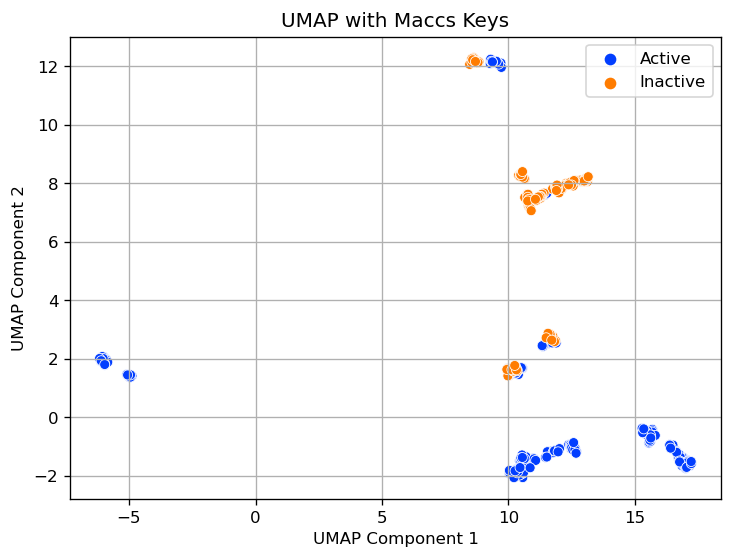

In [1606]:
plt.figure(figsize = (7, 5), dpi=120)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_maccs, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP with Maccs Keys', fontsize=12)
plt.show()

ML Functions for Fingerprint

In [1607]:
#Plot Data
def plot_curve_functions(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

    #if save_png:
        #fig.savefig(dpi=300, bbox_inches="tight", transparent=True)
    #return fig

In [1608]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [1609]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Split Data

In [1610]:
fp_to_model = compound_df.fp.tolist()
label_to_model = compound_df.activity_label.tolist()


(static_train_x, 
 static_test_x, 
 static_train_y,
 static_test_y) = train_test_split(fp_to_model, label_to_model, 
                                   test_size=0.2, random_state=42)

splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 324
Test data size: 82


Random Forest

In [1611]:
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy"
    #"max_depth": 3 # cost function to be optimized for a split
}
model_RF = RandomForestClassifier()

Accuracy: 0.98780
Sensitivity: 1.00000
Specificity: 0.95833
AUC: 0.99856
Confusion Matrix: [[23  1]
 [ 0 58]]


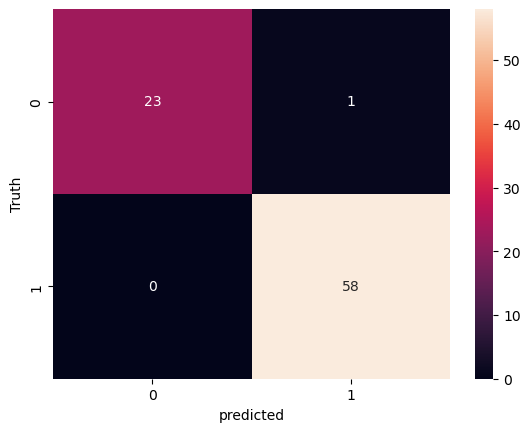

In [1612]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

In [1613]:
#feature_iris = pd.Series(model_RF.feature_importances_, index=compound_df.fp).sort_values(ascending=False)
#feature_iris

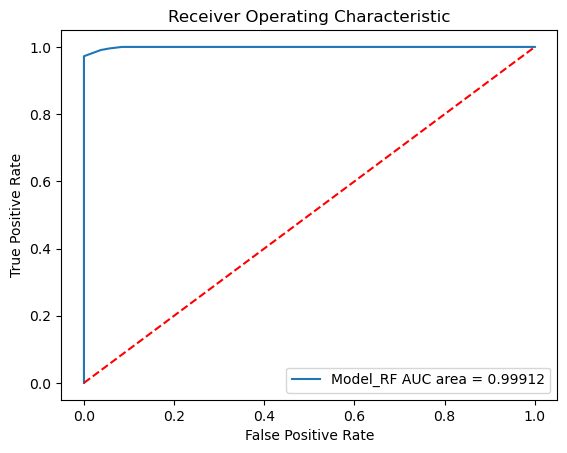

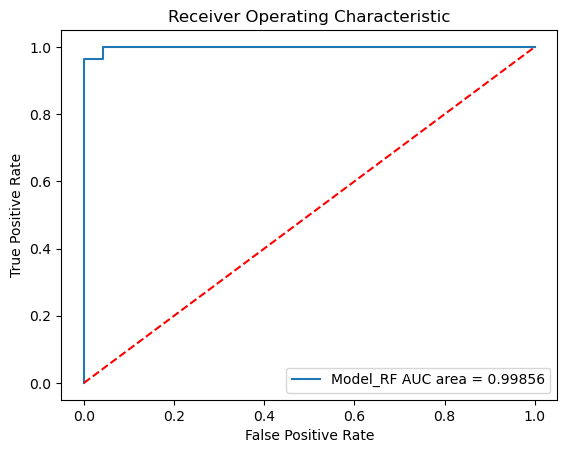

In [1614]:
models = [{"label": "Model_RF", "model": model_RF}]

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

SVM

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.99353
Confusion Matrix: [[24  0]
 [ 3 55]]


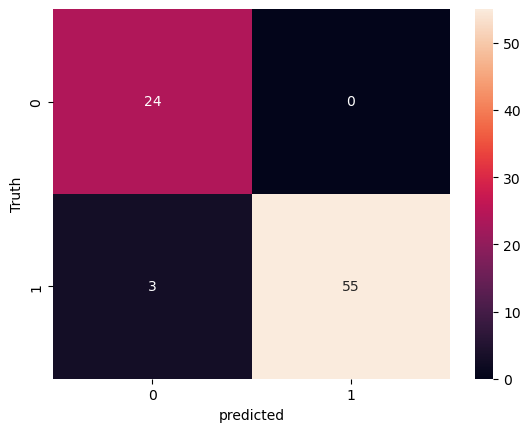

In [1615]:
model_SVM = svm.SVC(kernel="linear", C=1, gamma='scale', probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

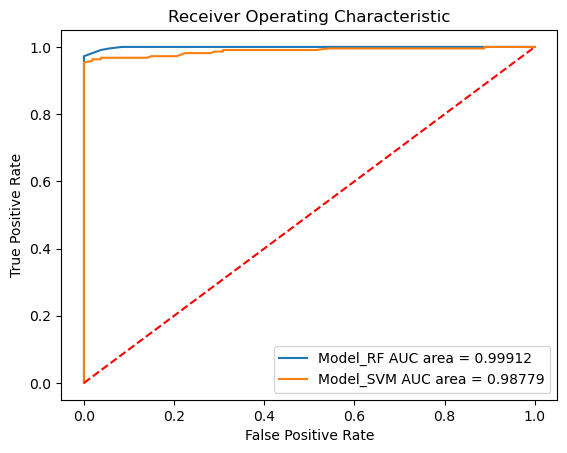

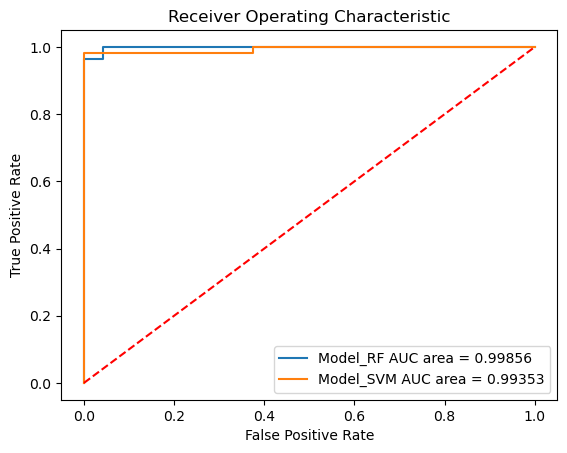

In [1616]:
models.append({"label": "Model_SVM", "model": model_SVM})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Gradient Boosting

In [1617]:
from sklearn.ensemble import GradientBoostingClassifier

Accuracy: 0.97561
Sensitivity: 0.98276
Specificity: 0.95833
AUC: 0.99928
Confusion Matrix: [[23  1]
 [ 1 57]]


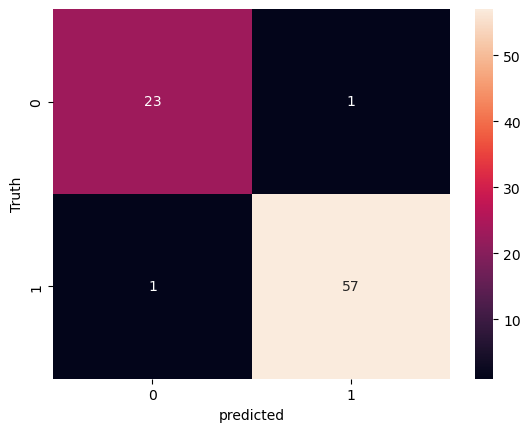

In [1618]:
model_GB = GradientBoostingClassifier(n_estimators=100,
                                     learning_rate=0.1,
                                     criterion='friedman_mse',
                                     max_depth=3)

performance_measures = model_training_and_validation(model_GB, "GB", splits)

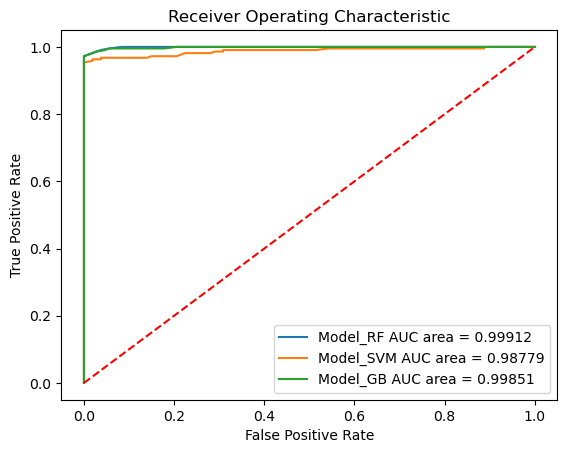

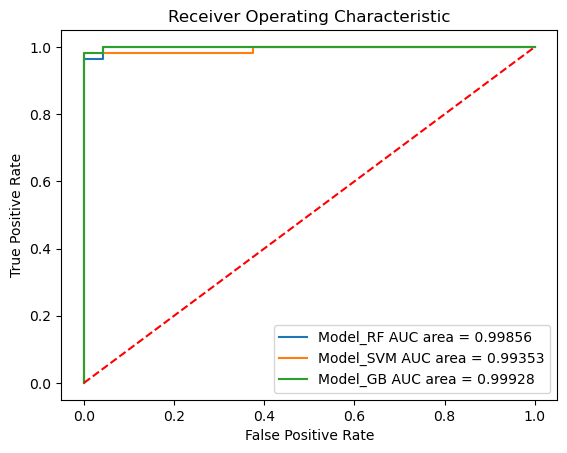

In [1619]:
models.append({"label": "Model_GB", "model": model_GB})

plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

ANN

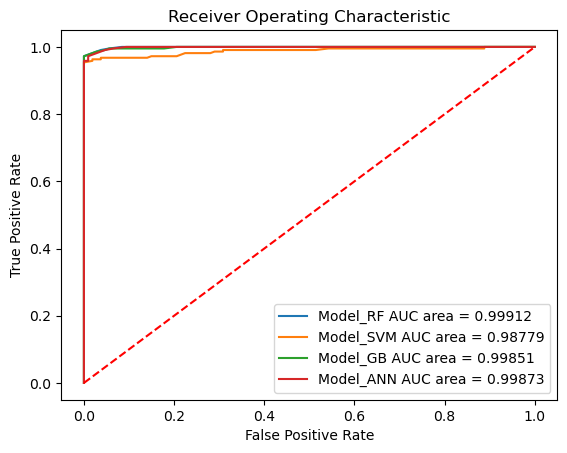

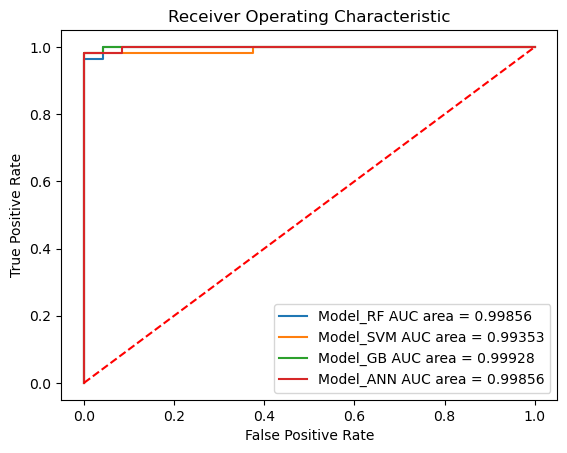

In [1621]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Classification Using Molecular Features

In [1622]:
df2

,cid,smiles,pIC50,activity_label
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0
...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0


In [1623]:
smile = [Chem.MolFromSmiles(i) for i in df2.smiles]
mol = [m for m in smile]
len(mol)

406

In [1624]:
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

209
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x000001A1721DC790>), ('MaxEStateIndex', <function MaxEStateIndex at 0x000001A1721DC670>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x000001A1721DC820>), ('MinEStateIndex', <function MinEStateIndex at 0x000001A1721DC700>), ('qed', <function qed at 0x000001A1721DF5B0>)]


In [1625]:
descriptors = [Descriptors.CalcMolDescriptors(i) for i in mol]
rdkit_gpr6 = pd.DataFrame(descriptors)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.187820,14.187820,0.034977,-0.532030,0.658737,473.980,444.748,473.199381,176,0,...,0,0,0,0,0,0,0,0,0,0
1,14.018710,14.018710,0.040537,-0.692270,0.679405,488.583,454.311,488.271131,190,0,...,0,0,0,0,0,0,0,0,0,1
2,15.077880,15.077880,0.007235,-1.401722,0.732420,463.504,435.280,463.219510,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.027118,14.027118,0.103907,-0.662901,0.619150,502.610,466.322,502.286781,196,0,...,0,0,0,0,0,0,0,0,0,0
4,14.030648,14.030648,0.373029,-5.083333,0.440062,523.506,497.298,523.200666,198,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,13.980299,13.980299,0.084153,-0.679987,0.688873,471.552,440.304,471.244582,182,0,...,0,0,0,0,0,0,0,0,0,0
402,13.250627,13.250627,0.029579,-3.463023,0.663173,487.626,454.362,487.225326,184,0,...,0,0,1,0,0,0,0,0,0,0
403,14.306601,14.306601,0.055294,-0.333280,0.747351,451.550,421.310,451.249587,174,0,...,0,0,0,0,0,0,0,0,0,0
404,14.017818,14.017818,0.082053,-0.681796,0.663656,500.594,466.322,500.271131,194,0,...,0,0,0,0,0,0,0,0,0,1


In [1626]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.0,...,406.000000,406.000000,406.000000,406.0,406.0,406.0,406.0,406.000000,406.000000,406.000000
mean,13.407435,13.407435,0.146775,-2.906237,0.551806,490.560377,465.303273,490.068246,181.921182,0.0,...,0.007389,0.068966,0.019704,0.0,0.0,0.0,0.0,0.022167,0.022167,0.054187
std,1.594267,1.594267,0.162150,2.097198,0.142109,77.633891,74.900296,77.514098,30.455532,0.0,...,0.085748,0.253708,0.139154,0.0,0.0,0.0,0.0,0.147410,0.163303,0.226666
min,4.871601,4.871601,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,13.003812,13.003812,0.040100,-5.083333,0.434120,457.531250,428.293000,457.233928,172.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,13.966414,13.966414,0.082684,-3.226666,0.554611,502.816000,472.048500,502.228169,190.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,14.176661,14.176661,0.202477,-0.682752,0.678792,538.844000,513.289750,538.190170,198.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.786402,0.716349,0.802254,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,1.000000


In [1627]:
df_descriptor = df2.copy()
df_dataset = df_descriptor[['activity_label']].join(rdkit_gpr6)
df_dataset

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,14.187820,14.187820,0.034977,-0.532030,0.658737,473.980,444.748,473.199381,176,...,0,0,0,0,0,0,0,0,0,0
1,1.0,14.018710,14.018710,0.040537,-0.692270,0.679405,488.583,454.311,488.271131,190,...,0,0,0,0,0,0,0,0,0,1
2,1.0,15.077880,15.077880,0.007235,-1.401722,0.732420,463.504,435.280,463.219510,178,...,0,0,0,0,0,0,0,0,0,0
3,1.0,14.027118,14.027118,0.103907,-0.662901,0.619150,502.610,466.322,502.286781,196,...,0,0,0,0,0,0,0,0,0,0
4,1.0,14.030648,14.030648,0.373029,-5.083333,0.440062,523.506,497.298,523.200666,198,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.0,13.980299,13.980299,0.084153,-0.679987,0.688873,471.552,440.304,471.244582,182,...,0,0,0,0,0,0,0,0,0,0
402,0.0,13.250627,13.250627,0.029579,-3.463023,0.663173,487.626,454.362,487.225326,184,...,0,0,1,0,0,0,0,0,0,0
403,0.0,14.306601,14.306601,0.055294,-0.333280,0.747351,451.550,421.310,451.249587,174,...,0,0,0,0,0,0,0,0,0,0
404,0.0,14.017818,14.017818,0.082053,-0.681796,0.663656,500.594,466.322,500.271131,194,...,0,0,0,0,0,0,0,0,0,1


Split Train Test set

In [1628]:
(feature_train_x, 
 feature_test_x, 
 feature_train_y,
 feature_test_y) = train_test_split(df_dataset.drop(['activity_label'], axis=1).values, 
                                    df_dataset['activity_label'].values, 
                                   test_size=0.2, random_state=42)

print("Training data size:", len(feature_train_x))
print("Test data size:", len(feature_test_x))
print(feature_train_x.shape)
print(feature_train_y.shape)


Training data size: 324
Test data size: 82
(324, 209)
(324,)


Standardization

In [1629]:
from sklearn import preprocessing

In [1630]:
scaler = preprocessing.StandardScaler()
scaler.fit(feature_train_x)

sd_train_x = scaler.transform(feature_train_x)
sd_train_x

array([[ 0.35140563,  0.35140563, -0.69491167, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 0.41167472,  0.41167472, -0.27456302, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 1.11408085,  1.11408085, -0.31938313, ..., -0.15911146,
        -0.15249857, -0.24958983],
       ...,
       [ 0.4995074 ,  0.4995074 , -0.37503354, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 0.35443189,  0.35443189, -0.43925025, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 1.06739313,  1.06739313, -0.12884383, ..., -0.15911146,
        -0.15249857, -0.24958983]])

In [1631]:
sd_test_x = scaler.transform(feature_test_x)
sd_test_x

array([[ 0.50612472,  0.50612472, -0.62808989, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [-0.39017006, -0.39017006, -0.41036562, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [-1.8250341 , -1.8250341 ,  3.83091413, ..., -0.15911146,
        -0.15249857, -0.24958983],
       ...,
       [ 0.35513686,  0.35513686, -0.56859056, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 0.38102218,  0.38102218, -0.84317722, ..., -0.15911146,
        -0.15249857, -0.24958983],
       [ 0.41822105,  0.41822105, -0.71190722, ..., -0.15911146,
        -0.15249857, -0.24958983]])

In [1632]:
df_sd_train_x = pd.DataFrame(sd_train_x, columns=rdkit_gpr6.columns)
df_sd_train_x.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,324.0,...,3.240000e+02,3.240000e+02,3.240000e+02,324.0,324.0,324.0,324.0,324.000000,3.240000e+02,3.240000e+02
mean,-1.346522e-14,-1.346522e-14,3.837808e-16,1.310337e-15,4.358653e-16,5.082354e-15,3.678813e-15,2.401371e-15,-7.127358e-17,0.0,...,-2.193033e-17,-3.289550e-17,-2.193033e-17,0.0,0.0,0.0,0.0,0.000000,2.467162e-17,7.127358e-17
std,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,0.0,...,1.001547e+00,1.001547e+00,1.001547e+00,0.0,0.0,0.0,0.0,1.001547,1.001547e+00,1.001547e+00
min,-4.978513e+00,-4.978513e+00,-9.189732e-01,-1.061165e+00,-2.209689e+00,-2.943056e+00,-2.806151e+00,-2.945377e+00,-3.157858e+00,0.0,...,-9.667365e-02,-2.828427e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-2.495898e-01
25%,-2.962141e-01,-2.962141e-01,-6.699350e-01,-1.061165e+00,-8.338578e-01,-4.401170e-01,-4.854872e-01,-4.379817e-01,-2.788204e-01,0.0,...,-9.667365e-02,-2.828427e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-2.495898e-01
50%,3.710243e-01,3.710243e-01,-4.145889e-01,-1.357924e-01,4.193147e-03,1.835027e-01,1.164734e-01,1.827460e-01,2.969871e-01,0.0,...,-9.667365e-02,-2.828427e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-2.495898e-01
75%,4.840473e-01,4.840473e-01,3.755178e-01,1.046196e+00,8.652486e-01,6.399153e-01,6.551401e-01,6.387115e-01,5.529015e-01,0.0,...,-9.667365e-02,-2.828427e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-2.495898e-01
max,1.204043e+00,1.204043e+00,3.958141e+00,1.703517e+00,1.730860e+00,2.047625e+00,2.176834e+00,2.046069e+00,1.960431e+00,0.0,...,1.034408e+01,3.535534e+00,6.729466e+00,0.0,0.0,0.0,0.0,6.284903,1.082740e+01,4.006574e+00


In [1633]:
df_sd_test_x = pd.DataFrame(sd_test_x, columns=rdkit_gpr6.columns)
df_sd_test_x.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.0,...,8.200000e+01,82.000000,82.000000,82.0,82.0,82.0,82.0,82.000000,8.200000e+01,82.000000
mean,0.048208,0.048208,-0.043086,-0.115627,-0.167505,0.145161,0.140551,0.146126,0.190876,0.0,...,-9.667365e-02,-0.096580,-0.064721,0.0,0.0,0.0,0.0,-0.080526,-1.524986e-01,-0.093877
std,1.159593,1.159593,1.027077,0.993199,0.995254,0.867520,0.876189,0.867959,0.846400,0.0,...,1.396319e-17,0.827574,0.759555,0.0,0.0,0.0,0.0,0.711622,1.396319e-16,0.803976
min,-5.526772,-5.526772,-0.901502,-1.061165,-2.172236,-2.955486,-2.832217,-2.957919,-3.157858,0.0,...,-9.667365e-02,-0.282843,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-0.249590
25%,-0.048539,-0.048539,-0.671811,-1.061165,-0.984808,-0.335880,-0.412539,-0.333762,-0.086885,0.0,...,-9.667365e-02,-0.282843,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-0.249590
50%,0.381165,0.381165,-0.388920,-0.275434,-0.234334,0.179999,0.152634,0.182370,0.360966,0.0,...,-9.667365e-02,-0.282843,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-0.249590
75%,0.534691,0.534691,0.078246,1.028226,0.767783,0.632379,0.642042,0.635920,0.616880,0.0,...,-9.667365e-02,-0.282843,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-1.524986e-01,-0.249590
max,1.133432,1.133432,3.830914,1.622357,1.450838,2.118731,2.176834,2.123624,2.152367,0.0,...,-9.667365e-02,3.535534,6.729466,0.0,0.0,0.0,0.0,6.284903,-1.524986e-01,4.006574


In [1634]:
df_feature_train_y = pd.DataFrame(feature_train_y, columns=['activity_label'])
df_feature_test_y = pd.DataFrame(feature_test_y, columns=['activity_label'])

In [1635]:
df_train_set = df_feature_train_y.join(df_sd_train_x)
df_train_set

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,0.351406,0.351406,-0.694912,-0.145486,-0.004671,0.367911,0.380599,0.371303,0.488923,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
1,1.0,0.411675,0.411675,-0.274563,1.046035,0.440682,0.180911,0.041691,0.183485,0.488923,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
2,1.0,1.114081,1.114081,-0.319383,-1.061165,-1.275186,1.387880,1.399859,1.392292,1.448602,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
3,1.0,-0.243881,-0.243881,0.704326,1.155877,1.302490,-2.602861,-2.479348,-2.604935,-2.837965,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
4,1.0,1.053929,1.053929,-0.453825,-1.061165,-0.887663,0.682554,0.720370,0.686279,0.744837,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1.0,0.432329,0.432329,-0.069353,-1.061165,-0.971751,1.199345,1.177829,1.203526,1.320645,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
320,1.0,0.483779,0.483779,-0.332151,-1.061165,-0.537573,0.392884,0.459176,0.396165,0.424944,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
321,1.0,0.499507,0.499507,-0.375034,1.119241,0.986245,-0.531661,-0.605830,-0.535836,-0.470756,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
322,0.0,0.354432,0.354432,-0.439250,1.035075,0.946934,-0.486986,-0.572621,-0.484979,-0.214842,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959


In [1636]:
df_test_set = df_feature_test_y.join(df_sd_test_x)
df_test_set

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.506125,0.506125,-0.628090,-1.061165,-0.619592,0.292452,0.302271,0.295606,0.424944,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
1,1.0,-0.390170,-0.390170,-0.410366,-1.061165,-0.632530,0.632144,0.681206,0.635731,0.680859,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
2,1.0,-1.825034,-1.825034,3.830914,-1.061165,-1.874187,1.079086,1.092488,1.076786,0.936773,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
3,1.0,0.332887,0.332887,-0.326728,-1.061165,-0.711543,0.468607,0.498288,0.471972,0.552902,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
4,1.0,0.547840,0.547840,-0.513569,-1.061165,-0.994441,0.657821,0.642042,0.661383,0.808816,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1.0,0.418519,0.418519,1.203767,-1.061165,-0.955907,0.569542,0.603061,0.572848,0.616880,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
78,0.0,0.392740,0.392740,-0.901502,0.146465,0.043936,0.242833,0.198112,0.245723,0.424944,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
79,0.0,0.355137,0.355137,-0.568591,-0.210709,0.861101,-0.083800,-0.140940,-0.082291,-0.022906,...,-0.096674,3.535534,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959
80,0.0,0.381022,0.381022,-0.843177,-0.101911,0.319081,0.091726,0.041260,0.094505,0.296987,...,-0.096674,-0.282843,-0.1486,0.0,0.0,0.0,0.0,-0.159111,-0.152499,-0.24959


In [1637]:
feature_name = np.array(df_sd_train_x.columns)
feature_name

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
 

UMAP plot (Fingerprint VS Features)

ML function for features

In [1638]:
def plot_curve_functions_feature(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

In [1639]:
def model_performance_feature(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [1640]:
def model_training_and_validation_feature(ml_model, name, splits_feature, verbose=True):

    train_x, test_x, train_y, test_y = splits_feature

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance_feature(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Random Forest (Features) with Boruta Feature Selection

In [1641]:
from boruta import BorutaPy
import xgboost as xgb


rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
ANN = MLPClassifier()
xgb = xgb.XGBClassifier()

In [1642]:
from boruta import BorutaPy

feat_selector = BorutaPy(rf, random_state=42, max_iter=100, n_estimators=100)
feat_selector.fit(df_train_set.drop(['activity_label'], axis=1).values, df_train_set['activity_label'].values) #fit to initial train set, then apply selected train x, y again into functions

BorutaPy(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x1A1188C2740),
         n_estimators=100, random_state=RandomState(MT19937) at 0x1A1188C2740)

In [1643]:
df_sd_train_x.columns[feat_selector.support_]

Index(['MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MaxPartialCharge',
       'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_CHGLO', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0n', 'Chi1n',
       'Chi4n', 'Kappa3', 'PEOE_VSA11', 'PEOE_VSA14', 'PEOE_VSA4', 'PEOE_VSA8',
       'SMR_VSA10', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA2', 'SlogP_VSA3',
       'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'EState_VSA2', 'VSA_EState3',
       'VSA_EState6', 'VSA_EState8', 'FractionCSP3',
       'NumAliphaticHeterocycles', 'NumAromaticRings'],
      dtype='object')

In [1644]:
feature_rank = list(zip(feature_name,
                    feat_selector.ranking_,
                    feat_selector.support_
                    ))

In [1645]:
for feat in feature_rank:
    print('Feature: {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: MaxAbsEStateIndex              Rank: 5, Keep: False
Feature: MaxEStateIndex                 Rank: 3, Keep: False
Feature: MinAbsEStateIndex              Rank: 1, Keep: True
Feature: MinEStateIndex                 Rank: 1, Keep: True
Feature: qed                            Rank: 1, Keep: True
Feature: MolWt                          Rank: 18, Keep: False
Feature: HeavyAtomMolWt                 Rank: 36, Keep: False
Feature: ExactMolWt                     Rank: 25, Keep: False
Feature: NumValenceElectrons            Rank: 5, Keep: False
Feature: NumRadicalElectrons            Rank: 141, Keep: False
Feature: MaxPartialCharge               Rank: 1, Keep: True
Feature: MinPartialCharge               Rank: 3, Keep: False
Feature: MaxAbsPartialCharge            Rank: 23, Keep: False
Feature: MinAbsPartialCharge            Rank: 2, Keep: False
Feature: FpDensityMorgan1               Rank: 38, Keep: False
Feature: FpDensityMorgan2               Rank: 10, Keep: False
Feature: FpDensityMo

In [1646]:
selected_feature_train_x = feat_selector.transform(sd_train_x)
print(selected_feature_train_x.shape)
print(feature_train_y.shape)


(324, 35)
(324,)


In [1647]:
selected_feature_test_x = feat_selector.transform(sd_test_x)
print(selected_feature_test_x.shape)
print(feature_test_y.shape)

(82, 35)
(82,)


UMAP plot based on selected features

In [1648]:
import umap.umap_ as umap
import umap.plot

In [1649]:
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=5,
                    metric='euclidean', 
                    random_state=42
                    )

In [1650]:
umap_desc_train = umapper.fit_transform(selected_feature_train_x)
umap_desc_test = umapper.fit_transform(selected_feature_test_x)

In [1651]:
umap_desc_train_x = pd.DataFrame(umap_desc_train[:, 0], columns = ['x'])
umap_desc_train_y = pd.DataFrame(umap_desc_train[:, 1], columns = ['y'])
activity_label = pd.DataFrame(df_train_set['activity_label'], columns = ['activity_label'])
plot_umap_desc_train = pd.concat([activity_label, umap_desc_train_x, umap_desc_train_y], axis = 1)
plot_umap_desc_train

,activity_label,x,y
0,0.0,15.017066,10.636883
1,1.0,14.457458,11.571009
2,1.0,2.157736,7.348914
3,1.0,-7.818984,2.815392
4,1.0,1.591960,7.080840
...,...,...,...
319,1.0,1.743972,7.410080
320,1.0,1.072022,7.232615
321,1.0,14.434355,12.455176
322,0.0,14.510587,12.431904


In [1652]:
umap_desc_test_x = pd.DataFrame(umap_desc_test[:, 0], columns = ['x'])
umap_desc_test_y = pd.DataFrame(umap_desc_test[:, 1], columns = ['y'])
activity_label = pd.DataFrame(df_test_set['activity_label'], columns = ['activity_label'])
plot_umap_desc_test = pd.concat([activity_label, umap_desc_test_x, umap_desc_test_y], axis = 1)
plot_umap_desc_test

,activity_label,x,y
0,1.0,17.748852,14.030806
1,1.0,17.835007,12.972031
2,1.0,17.645489,12.892832
3,1.0,17.739603,13.494014
4,1.0,17.666595,14.356978
...,...,...,...
77,1.0,17.856701,13.069765
78,0.0,6.775804,8.195539
79,0.0,7.258625,8.959332
80,0.0,6.876312,8.052647


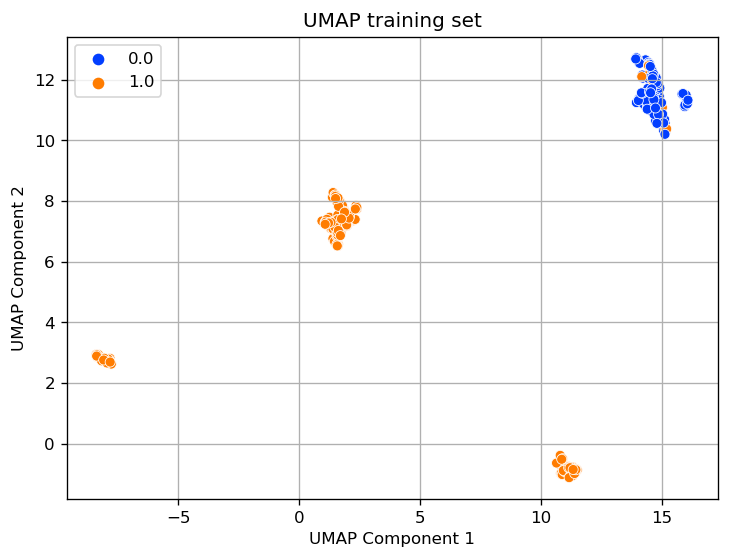

In [1653]:
plt.figure(figsize = (7, 5), dpi=120)
sns.scatterplot(x='x', y='y', hue='activity_label', data=plot_umap_desc_train, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP training set', fontsize=12)
plt.show()

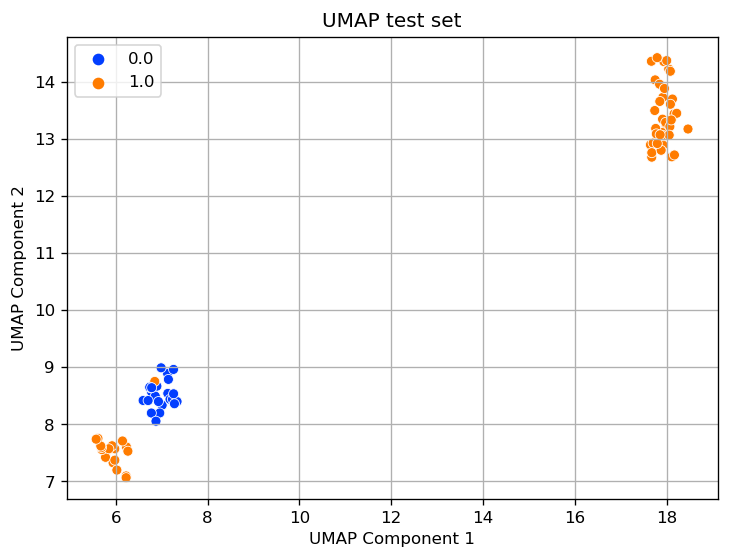

In [1654]:
plt.figure(figsize = (7, 5), dpi=120)
sns.scatterplot(x='x', y='y', hue='activity_label', data=plot_umap_desc_test, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP test set', fontsize=12)
plt.show()

Optimize Hyperparameter

In [1655]:
import sklearn
import sklearn.model_selection
import optuna #optimize hyperparameter

SVM Param Optimization

In [1675]:
def objective_SVC(trial):
    
    X, y = selected_feature_train_x, feature_train_y


    param = {
    'C' : trial.suggest_float('C', 1e-14, 1e4, log=True),
    'kernel' : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
    'gamma' : trial.suggest_categorical('gamma', ['scale', 'auto']),
    'degree' : trial.suggest_int('degree', 1, 3),
    }
    
    classifier_obj = svm.SVC(**param)
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, cv=5)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')#, sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective_SVC, n_trials=20)
    
    print('Best trial:', study.best_trial)
    print('Best Parameter:', study.best_params)
    print('Best value:', study.best_value)

[I 2023-08-30 21:04:34,938] A new study created in memory with name: no-name-ef076852-1b82-4a78-8b66-5b494ad2d7b0
[I 2023-08-30 21:04:34,960] Trial 0 finished with value: 0.6697596153846155 and parameters: {'C': 3.2090151579955053e-10, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.6697596153846155.
[I 2023-08-30 21:04:34,977] Trial 1 finished with value: 0.6697596153846155 and parameters: {'C': 4.53113515209834e-08, 'kernel': 'linear', 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.6697596153846155.
[I 2023-08-30 21:04:34,995] Trial 2 finished with value: 0.6697596153846155 and parameters: {'C': 8.096969886432491e-09, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.6697596153846155.
[I 2023-08-30 21:04:35,017] Trial 3 finished with value: 0.9691346153846154 and parameters: {'C': 0.000723825699446386, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2}. Best is trial 3 with value: 0.9691346153846154.
[I 202

Best trial: FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9691346153846154], datetime_start=datetime.datetime(2023, 8, 30, 21, 4, 34, 996103), datetime_complete=datetime.datetime(2023, 8, 30, 21, 4, 35, 17036), params={'C': 0.000723825699446386, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000.0, log=True, low=1e-14, step=None), 'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf')), 'gamma': CategoricalDistribution(choices=('scale', 'auto')), 'degree': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=3, value=None)
Best Parameter: {'C': 0.000723825699446386, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2}
Best value: 0.9691346153846154


In [1676]:
splits_feature = [selected_feature_train_x, selected_feature_test_x, feature_train_y, feature_test_y]

Accuracy: 0.98780
Sensitivity: 0.98276
Specificity: 1.00000
AUC: 0.99497
Confusion Matrix: [[24  0]
 [ 1 57]]


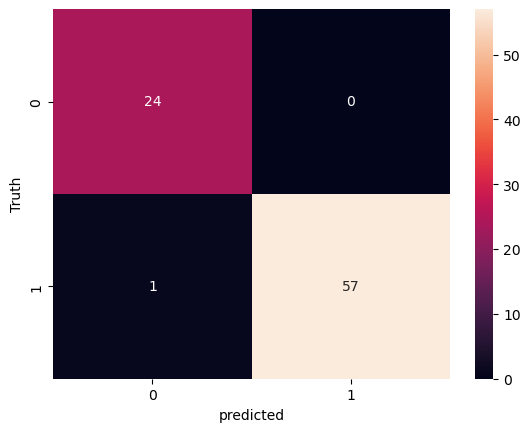

In [1677]:
selected_model_SVC = svm.SVC(**study.best_params, probability=True)

performance_measures = model_training_and_validation_feature(selected_model_SVC, "model", splits_feature)

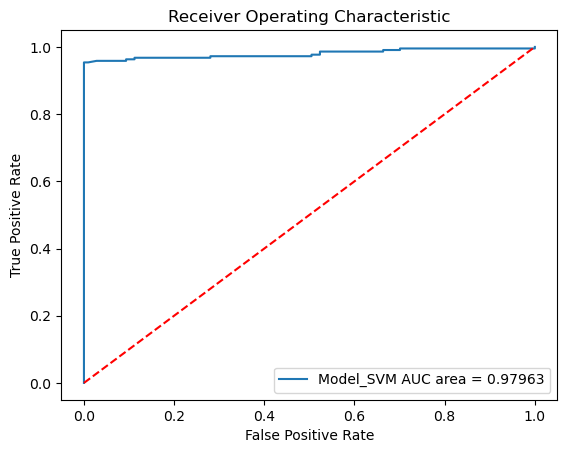

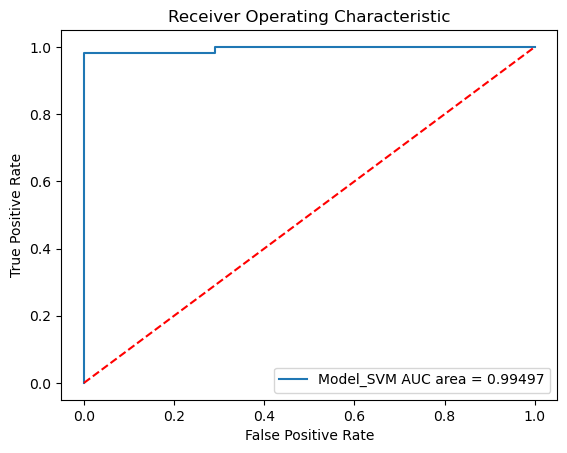

In [1678]:
models = [{"label": "Model_SVM", "model": selected_model_SVC}]

plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)
plot_curve_functions_feature(models, selected_feature_test_x, feature_test_y)

Random Forest Param Optimization

In [1679]:
def objective_RF(trial):
    
    X, y = selected_feature_train_x, feature_train_y
    
    param = {
    'max_depth' : trial.suggest_int('max_depth', 2, 20, log=True),
    'n_estimators' : trial.suggest_int('n_estimators', 2, 100),
    'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
    }
    
    classifier_obj = RandomForestClassifier(**param)
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')#, sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective_RF, n_trials=20)
    
    print('Best Parameter:', study.best_params)
    print('Best value:', study.best_value)

[I 2023-08-30 21:04:36,524] A new study created in memory with name: no-name-b756c81d-3b4d-4f7a-a563-1a7cabe92a13
[I 2023-08-30 21:04:38,260] Trial 0 finished with value: 0.9629807692307694 and parameters: {'max_depth': 17, 'n_estimators': 95, 'criterion': 'gini'}. Best is trial 0 with value: 0.9629807692307694.
[I 2023-08-30 21:04:39,189] Trial 1 finished with value: 0.9691346153846154 and parameters: {'max_depth': 2, 'n_estimators': 36, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.9691346153846154.
[I 2023-08-30 21:04:39,283] Trial 2 finished with value: 0.9599038461538463 and parameters: {'max_depth': 14, 'n_estimators': 34, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.9691346153846154.
[I 2023-08-30 21:04:39,314] Trial 3 finished with value: 0.9629326923076924 and parameters: {'max_depth': 10, 'n_estimators': 6, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.9691346153846154.
[I 2023-08-30 21:04:39,421] Trial 4 finished with value: 0.9660576923076925 

Best Parameter: {'max_depth': 2, 'n_estimators': 36, 'criterion': 'log_loss'}
Best value: 0.9691346153846154


Accuracy: 0.98780
Sensitivity: 0.98276
Specificity: 1.00000
AUC: 1.00000
Confusion Matrix: [[24  0]
 [ 1 57]]


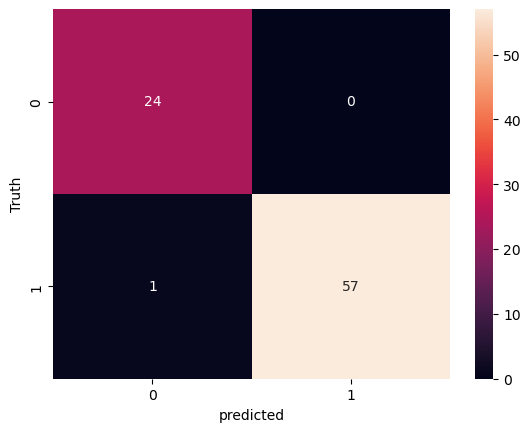

In [1680]:
selected_model_RF = RandomForestClassifier(**study.best_params)

performance_measures = model_training_and_validation_feature(selected_model_RF, "model", splits_feature)

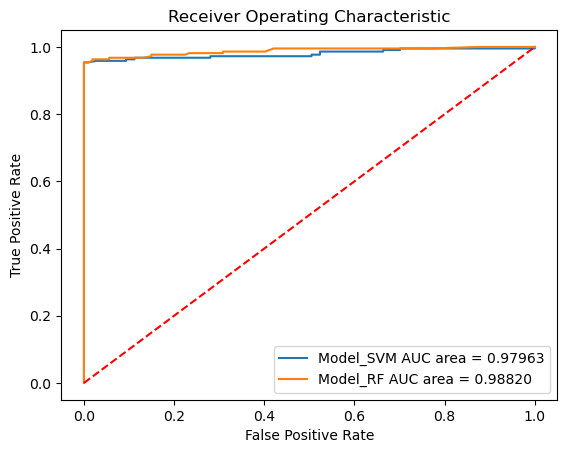

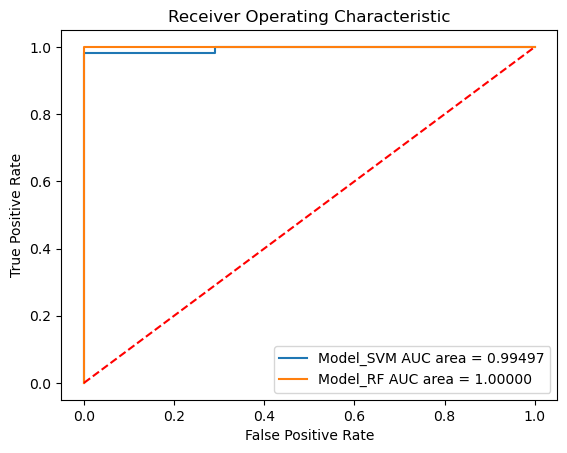

In [1681]:
models.append({"label": "Model_RF", "model": selected_model_RF})

plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)
plot_curve_functions_feature(models, selected_feature_test_x, feature_test_y)

Gradient Boosting Param Optimization

In [1682]:
def objective_GB(trial):
    
    X, y = selected_feature_train_x, feature_train_y
    
    param = {
    'learning_rate' : trial.suggest_float('learning_rate', 0.0, 0.2),
    'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'criterion' : trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
    'max_depth' : trial.suggest_int('max_depth', 1, 5),
    'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.0, 1.0)
    }
    
    classifier_obj = GradientBoostingClassifier(**param)
    
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    
    accuracy = score.mean()
        
    return accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')#, sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective_GB, n_trials=20)
    print('Best Parameter:', study.best_params)
    print('Best value:', study.best_value)

[I 2023-08-30 21:04:41,805] A new study created in memory with name: no-name-4e042acd-9c6b-4957-9b1b-9ab7893ee036
[I 2023-08-30 21:04:42,257] Trial 0 finished with value: 0.6697596153846155 and parameters: {'learning_rate': 0.027717937971009923, 'n_estimators': 52, 'criterion': 'friedman_mse', 'max_depth': 5, 'ccp_alpha': 0.9379269791030758}. Best is trial 0 with value: 0.6697596153846155.
[I 2023-08-30 21:04:42,585] Trial 1 finished with value: 0.6697596153846155 and parameters: {'learning_rate': 0.12356500438227036, 'n_estimators': 57, 'criterion': 'friedman_mse', 'max_depth': 3, 'ccp_alpha': 0.4408363736551747}. Best is trial 0 with value: 0.6697596153846155.
[I 2023-08-30 21:04:42,741] Trial 2 finished with value: 0.9568269230769232 and parameters: {'learning_rate': 0.16899968950081182, 'n_estimators': 67, 'criterion': 'friedman_mse', 'max_depth': 1, 'ccp_alpha': 0.0783085407962264}. Best is trial 2 with value: 0.9568269230769232.
[I 2023-08-30 21:04:42,928] Trial 3 finished with v

Best Parameter: {'learning_rate': 0.1993797701654596, 'n_estimators': 100, 'criterion': 'friedman_mse', 'max_depth': 4, 'ccp_alpha': 0.004996850222480087}
Best value: 0.9599038461538463


Accuracy: 0.98780
Sensitivity: 0.98276
Specificity: 1.00000
AUC: 1.00000
Confusion Matrix: [[24  0]
 [ 1 57]]


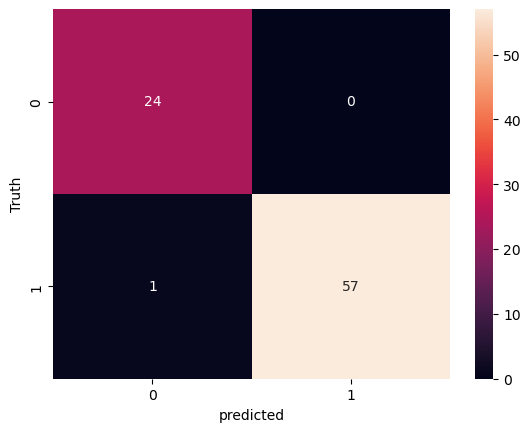

In [1683]:
selected_model_GB = GradientBoostingClassifier(**study.best_params)

performance_measures = model_training_and_validation_feature(selected_model_GB, "model", splits_feature)

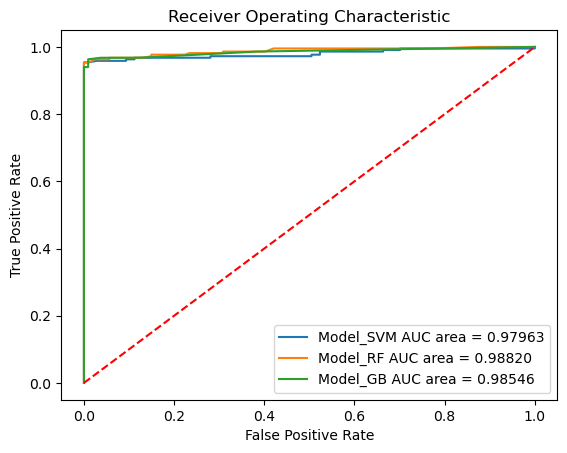

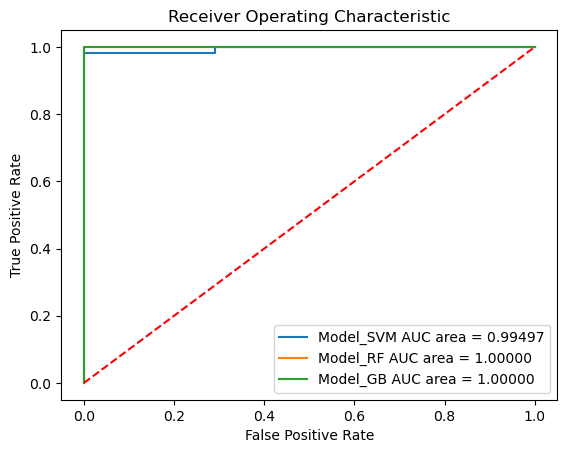

In [1684]:
models.append({"label": "Model_GB", "model": selected_model_GB})

plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)
plot_curve_functions_feature(models, selected_feature_test_x, feature_test_y)

Neural Network Param Optimization

In [1685]:
def objective_NN(trial):
    
    X, y = selected_feature_train_x, feature_train_y
    
    param = {
    'solver' : 'lbfgs', #For small dataset
    'hidden_layer_sizes' : trial.suggest_int('hidden_layer_sizes', 2, 100),
    'activation' : trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'alpha' : trial.suggest_float('alpha', 1e-4, 1, log=True)
    }
    
    classifier_obj = MLPClassifier(**param)
    
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')#, sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective_NN, n_trials=20)
    print('Best Parameter:', study.best_params)
    print('Best value:', study.best_value)

[I 2023-08-30 21:04:50,851] A new study created in memory with name: no-name-6d43581b-cf22-445c-b60f-d6d42f27d46f
[I 2023-08-30 21:04:51,041] Trial 0 finished with value: 0.9537500000000001 and parameters: {'hidden_layer_sizes': 61, 'activation': 'relu', 'alpha': 0.0020815625347583785}. Best is trial 0 with value: 0.9537500000000001.
[I 2023-08-30 21:04:51,164] Trial 1 finished with value: 0.9444711538461539 and parameters: {'hidden_layer_sizes': 27, 'activation': 'tanh', 'alpha': 0.0021212490296424434}. Best is trial 0 with value: 0.9537500000000001.
[I 2023-08-30 21:04:51,211] Trial 2 finished with value: 0.9599038461538463 and parameters: {'hidden_layer_sizes': 4, 'activation': 'identity', 'alpha': 0.5060728278001172}. Best is trial 2 with value: 0.9599038461538463.
[I 2023-08-30 21:04:51,289] Trial 3 finished with value: 0.9537019230769233 and parameters: {'hidden_layer_sizes': 22, 'activation': 'identity', 'alpha': 0.21283079755883552}. Best is trial 2 with value: 0.95990384615384

Best Parameter: {'hidden_layer_sizes': 4, 'activation': 'logistic', 'alpha': 0.750956447276413}
Best value: 0.9691346153846154


c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.97561
Sensitivity: 0.96552
Specificity: 1.00000
AUC: 0.99425
Confusion Matrix: [[24  0]
 [ 2 56]]


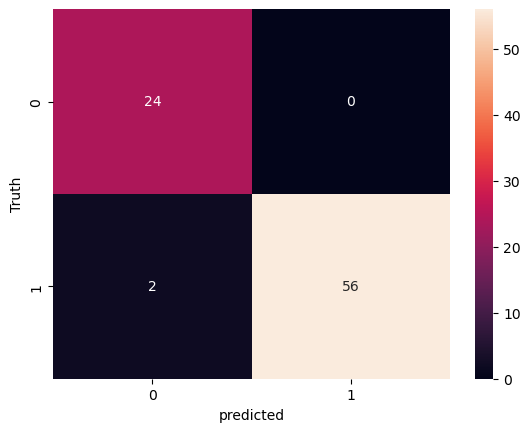

In [1686]:
selected_model_ANN = MLPClassifier(**study.best_params)

performance_measures = model_training_and_validation_feature(selected_model_ANN, "ANN", splits_feature)

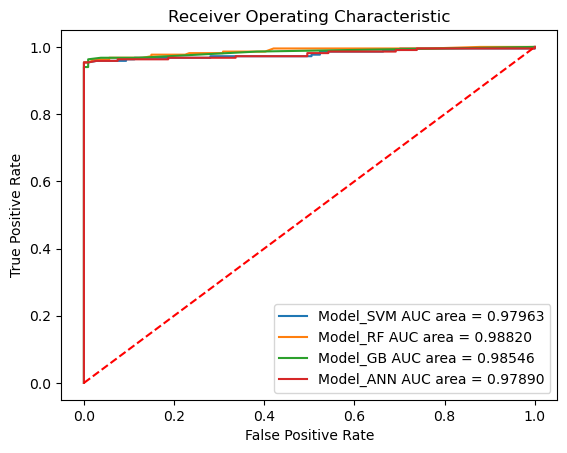

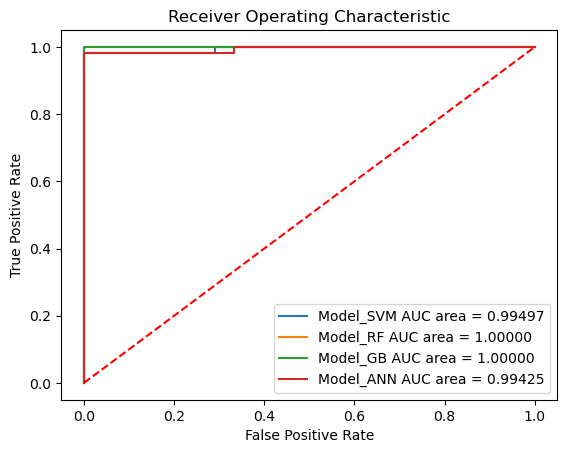

In [1687]:
models.append({"label": "Model_ANN", "model": selected_model_ANN})

plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)
plot_curve_functions_feature(models, selected_feature_test_x, feature_test_y)

XGBoost Param Optimization

In [1688]:
import xgboost as xgb

In [1689]:
def objective_xgb(trial):
    
    X, y = selected_feature_train_x, feature_train_y
    
    dtrain = xgb.DMatrix(selected_feature_train_x, label=feature_train_y)
    dtest = xgb.DMatrix(selected_feature_test_x, label=feature_test_y)
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    classifier_obj = xgb.XGBClassifier(**param)
    #bst = xgb.train(param, dtrain)
    #preds = bst.predict(dtest)
    #pred_labels = np.rint(preds)
    #accuracy = sklearn.metrics.accuracy_score(feature_test_y, pred_labels)
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")#, sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective_xgb, n_trials=20, timeout=600)
    
    print('Best Parameter:', study.best_params)
    print('Best value:', study.best_value)
    
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2023-08-30 21:04:54,291] A new study created in memory with name: no-name-a5d12dff-7e3b-4ee4-b218-863fa50a1277
[I 2023-08-30 21:04:55,067] Trial 0 finished with value: 0.9568269230769232 and parameters: {'booster': 'dart', 'lambda': 0.0495305673967765, 'alpha': 0.03186305821903579, 'subsample': 0.8108056068790683, 'colsample_bytree': 0.753157070408, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.005080390377346366, 'gamma': 0.02029557189176353, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.24084857506208832, 'skip_drop': 0.40604296010951896}. Best is trial 0 with value: 0.9568269230769232.
[I 2023-08-30 21:04:55,755] Trial 1 finished with value: 0.9629807692307694 and parameters: {'booster': 'dart', 'lambda': 3.550551082650292e-05, 'alpha': 0.03683644772005182, 'subsample': 0.8424686967532722, 'colsample_bytree': 0.2472505467613315, 'max_depth': 3, 'min_child_weight': 8, 'eta': 7.238014932811812e-08, 'gamma': 8.161237967582505e-08,

Best Parameter: {'booster': 'gblinear', 'lambda': 0.00228322369544713, 'alpha': 0.001836624424924434, 'subsample': 0.4076404806043983, 'colsample_bytree': 0.43054678420526377}
Best value: 0.9691346153846154
Number of finished trials:  20
Best trial:
  Value: 0.9691346153846154
  Params: 
    booster: gblinear
    lambda: 0.00228322369544713
    alpha: 0.001836624424924434
    subsample: 0.4076404806043983
    colsample_bytree: 0.43054678420526377


Train model using training set

Accuracy: 0.98780
Sensitivity: 0.98276
Specificity: 1.00000
AUC: 0.99928
Confusion Matrix: [[24  0]
 [ 1 57]]


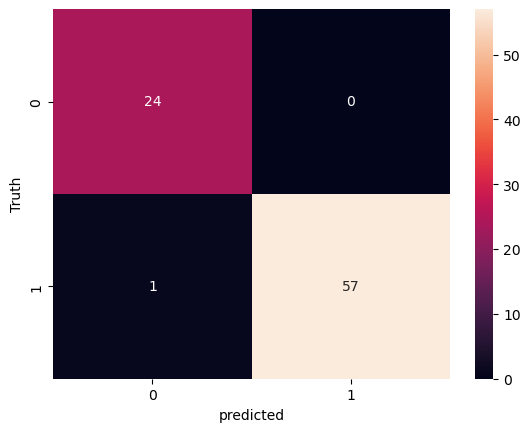

In [1690]:
selected_model_3 = xgb.XGBClassifier(**study.best_params)

performance_measures = model_training_and_validation_feature(selected_model_3, "XGB", splits_feature)

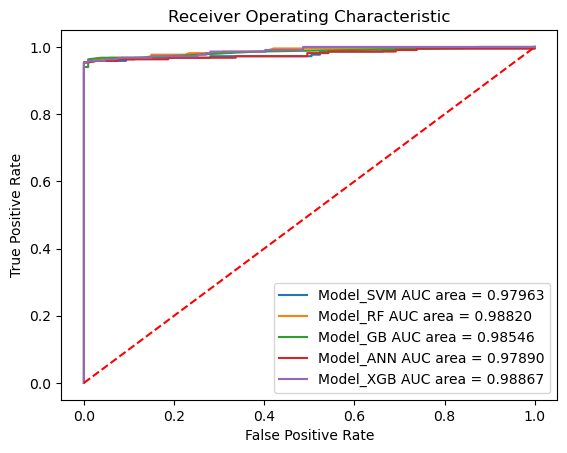

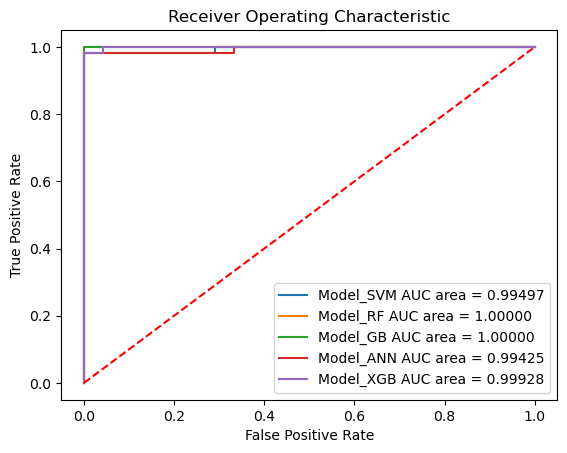

In [1691]:
models.append({"label": "Model_XGB", "model": selected_model_3})

plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)
plot_curve_functions_feature(models, selected_feature_test_x, feature_test_y)

In [1692]:
#feature_importance_GB = pd.Series(model_GB_feature.feature_importances_, index=rdkit_gpr6.columns).sort_values(ascending=False)
#feature_importance_GB.head(10)

Hyperparameter Searching

In [1693]:
#def report_best_scores(results, n_top=3):
#    for i in range(1, n_top + 1):
#        candidates = np.flatnonzero(results['rank_test_score'] == i)
#        for candidate in candidates:
#            print("Model with rank: {0}".format(i))
#            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                  results['mean_test_score'][candidate],
#                  results['std_test_score'][candidate]))
#            print("Parameters: {0}".format(results['params'][candidate]))
#            print("")